# Realtime VAD

Let say you want to cut your realtime recording audio by using VAD, malaya-speech able to do that.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-vad).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int

Cannot import beam_search_ops from Tensorflow Addons, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] will not available to use, make sure Tensorflow Addons version >= 0.12.0
check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases
/Users/huseinzolkepli/.pyenv/versions/3.9.4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchaudio.io.StreamReader exception: FFmpeg libraries are not found. Please install FFmpeg.
`torchaudio.io.StreamReader` is not available, `malaya_speech.streaming.torchaudio.stream` is not able to use.
`openai-whisper` is not available, native whisper processor is not available, will use huggingface processor instead.
`torchaudio.io.StreamReader` is not available, `

### Load VAD model

Fastest and common model people use, is webrtc. Read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [2]:
webrtc = malaya_speech.vad.webrtc()

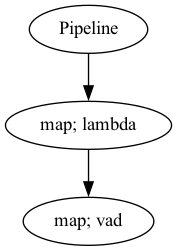

In [3]:
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(webrtc)
)
p_vad.visualize()

Starting malaya-speech 1.4.0, streaming always returned a float32 array between -1 and +1 values.

### Streaming interface

```python
def stream(
    vad_model=None,
    asr_model=None,
    classification_model=None,
    sample_rate: int = 16000,
    segment_length: int = 2560,
    num_padding_frames: int = 20,
    ratio: float = 0.75,
    min_length: float = 0.1,
    max_length: float = 10.0,
    realtime_print: bool = True,
    **kwargs,
):
    """
    Stream an audio using pyaudio library.

    Parameters
    ----------
    vad_model: object, optional (default=None)
        vad model / pipeline.
    asr_model: object, optional (default=None)
        ASR model / pipeline, will transcribe each subsamples realtime.
    classification_model: object, optional (default=None)
        classification pipeline, will classify each subsamples realtime.
    device: None, optional (default=None)
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    segment_length: int, optional (default=2560)
        usually derived from asr_model.segment_length * asr_model.hop_length,
        size of audio chunks, actual size in term of second is `segment_length` / `sample_rate`.
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (second) to accept a subsample.
    max_length: float, optional (default=10.0)
        maximum length (second) to accept a subsample.
    realtime_print: bool, optional (default=True)
        Will print results for ASR.
    **kwargs: vector argument
        vector argument pass to malaya_speech.streaming.pyaudio.Audio interface.

    Returns
    -------
    result : List[dict]
    """
```

**Once you start to run the code below, it will straight away recording your voice**. Right now I am using built-in microphone.

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [4]:
samples = malaya_speech.streaming.pyaudio.stream(vad_model = p_vad, segment_length = 320)

In [5]:
len(samples)

4

In [6]:
import IPython.display as ipd
import numpy as np

In [7]:
ipd.Audio(samples[-1]['wav_data'], rate = 16000)

In [8]:
ipd.Audio(np.concatenate([s['wav_data'] for s in samples]), rate = 16000)

### Use deep learning

We know, webrtc does not work really good in noisy environment, so to improve that, we can use VAD deep model from malaya-speech.

In [9]:
vad_model = malaya_speech.vad.deep_model(model = 'vggvox-v2')

/Users/huseinzolkepli/Documents/dev/malaya-speech/malaya_speech/utils/featurization.py:38: FutureWarning: Pass sr=16000, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.mel_basis = librosa.filters.mel(


**Once you start to run the code below, it will straight away recording your voice**. Right now I am using built-in microphone.

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

deep learning model trained on 50 ms and bigger frames, so, 16000 * 0.05 = 800

In [20]:
samples = malaya_speech.streaming.pyaudio.stream(vad_model, segment_length = 800)

### Use Silero VAD

Originally from https://github.com/snakers4/silero-vad

In [23]:
import numpy as np
import torch

model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad')

Using cache found in /Users/huseinzolkepli/.cache/torch/hub/snakers4_silero-vad_master


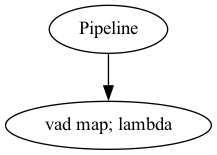

In [24]:
p = Pipeline()
pipeline = (
    p.map(lambda x: model(torch.tensor(x.astype(np.float32)), 16000).numpy()[0][0] >= 0.5, name = 'vad')
)
p.visualize()

**If you are using vilero VAD, `segment_length` must >= 640**.

In [25]:
samples = malaya_speech.streaming.pyaudio.stream(p, segment_length = 640)

In [26]:
len(samples)

1

In [27]:
ipd.Audio(samples[0]['wav_data'], rate = 16000)